In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.hidden(inputs)

# Initialize the PINN
model = PINN()

# Define the loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training points
N_collocation = 1000  # Number of PDE enforcement points
x_collocation = torch.linspace(0, 1, N_collocation, requires_grad=True).view(-1, 1)
t_collocation = torch.linspace(0, 1, N_collocation, requires_grad=True).view(-1, 1)

# Boundary and initial conditions
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32, requires_grad=True)
t_boundary = torch.zeros_like(x_boundary)  # Ensure t_boundary matches x_boundary shape
u_boundary = torch.tensor([[0.0], [0.0]], dtype=torch.float32)

x_initial = torch.linspace(0, 1, N_collocation, requires_grad=True).view(-1, 1)
t_initial = torch.zeros_like(x_initial)
u_initial = torch.sin(np.pi * x_initial)

# Thermal diffusivity
alpha = 0.1

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Compute u_theta(x, t)
    u = model(x_collocation, t_collocation)

    # Compute first derivative du/dt
    du_dt = torch.autograd.grad(u, t_collocation, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    # Compute first derivative du/dx
    du_dx = torch.autograd.grad(u, x_collocation, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    # Compute second derivative d^2u/dx^2
    d2u_dx2 = torch.autograd.grad(du_dx, x_collocation, torch.ones_like(du_dx), create_graph=True, retain_graph=True)[0]

    # Physics loss: enforcing Heat equation (du/dt - alpha * d^2u/dx^2 = 0)
    physics_loss = torch.mean((du_dt - alpha * d2u_dx2) ** 2)

    # Boundary loss: enforcing u(0, t) = u(1, t) = 0
    u_b = model(x_boundary, t_boundary)
    boundary_loss = torch.mean((u_b - u_boundary) ** 2)

    # Initial loss: enforcing u(x, 0) = sin(pi * x)
    u_i = model(x_initial, t_initial)
    initial_loss = torch.mean((u_i - u_initial) ** 2)

    # Total loss
    loss = physics_loss + boundary_loss + initial_loss

    # Backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 0.526491
Epoch 500, Loss: 0.000049
Epoch 1000, Loss: 0.000008
Epoch 1500, Loss: 0.000004
Epoch 2000, Loss: 0.001479
Epoch 2500, Loss: 0.000009
Epoch 3000, Loss: 0.000006
Epoch 3500, Loss: 0.000006
Epoch 4000, Loss: 0.000005
Epoch 4500, Loss: 0.000005
Epoch 5000, Loss: 0.000009
Epoch 5500, Loss: 0.000004
Epoch 6000, Loss: 0.000003
Epoch 6500, Loss: 0.000518
Epoch 7000, Loss: 0.000061
Epoch 7500, Loss: 0.000007
Epoch 8000, Loss: 0.000002
Epoch 8500, Loss: 0.000722
Epoch 9000, Loss: 0.000008
Epoch 9500, Loss: 0.000079


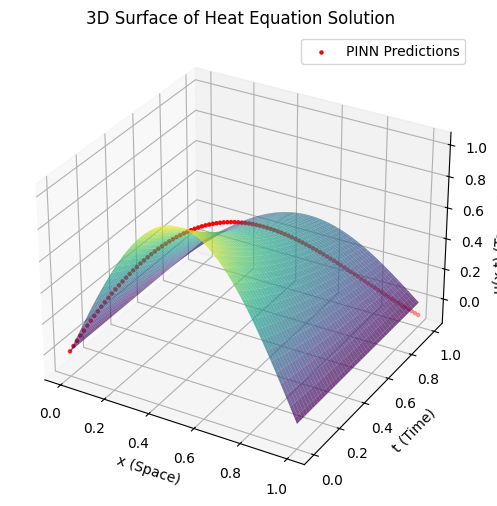

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# Generate test points
x_test = torch.linspace(0, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)

# Compute PINN predictions
u_pred = model(x_test, t_test).detach().numpy()

# Create a mesh grid for visualization
X, T = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# Compute the exact solution
U_exact = np.exp(-alpha * np.pi**2 * T) * np.sin(np.pi * X)

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the exact solution as a surface
ax.plot_surface(X, T, U_exact, cmap="viridis", alpha=0.7, edgecolor='none')

# Plot PINN predictions as scatter points
ax.scatter(x_test.numpy(), t_test.numpy(), u_pred, color='r', s=5, label="PINN Predictions")

# Labels and title
ax.set_xlabel("x (Space)")
ax.set_ylabel("t (Time)")
ax.set_zlabel("u(x,t) (Temperature)")
ax.set_title("3D Surface of Heat Equation Solution")

# Show the plot
plt.legend()
plt.show()


Evaluation Metrics:
Mean Squared Error (MSE): 1.498580e-03
Mean Absolute Error (MAE): 3.160384e-02
Relative Error: 0.083178
R² Score: 0.973196


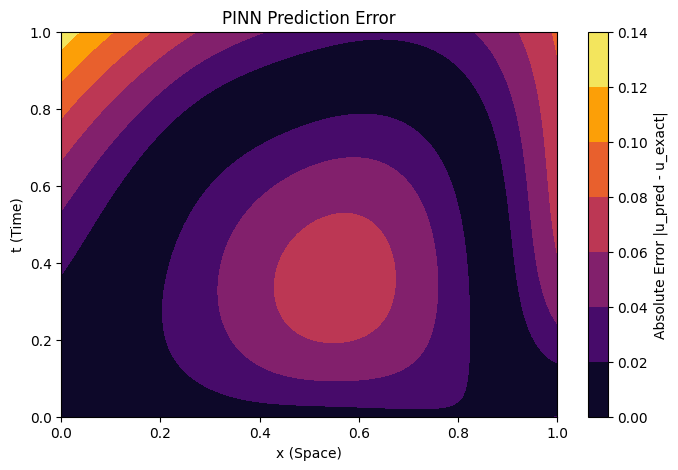

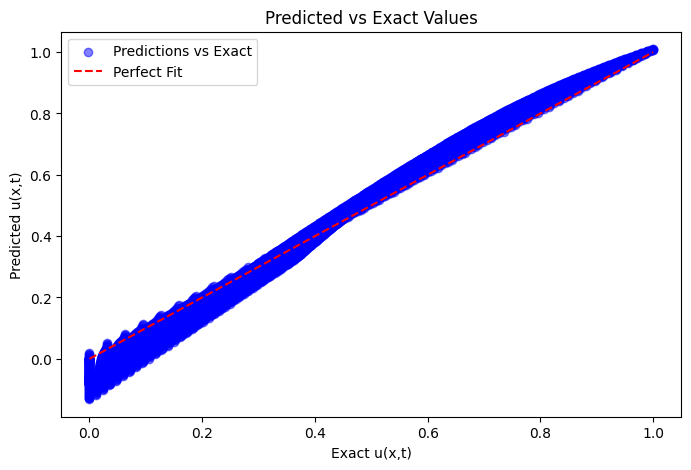

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Generate test mesh grid
x_test_vals = np.linspace(0, 1, 100)  # 100 points in x
t_test_vals = np.linspace(0, 1, 100)  # 100 points in t
X_test, T_test = np.meshgrid(x_test_vals, t_test_vals)

# Convert test grid to PyTorch tensors
x_test = torch.tensor(X_test.flatten(), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(T_test.flatten(), dtype=torch.float32).view(-1, 1)

# Compute PINN predictions on the mesh grid
u_pred = model(x_test, t_test).detach().numpy().reshape(100, 100)

# Compute the exact solution at the same points
U_exact = np.exp(-alpha * np.pi**2 * T_test) * np.sin(np.pi * X_test)

# Compute evaluation metrics
mse = np.mean((u_pred - U_exact) ** 2)
mae = np.mean(np.abs(u_pred - U_exact))
relative_error = np.linalg.norm(u_pred - U_exact) / np.linalg.norm(U_exact)
r2 = r2_score(U_exact.flatten(), u_pred.flatten())

# Print results
print(f"Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6e}")
print(f"Mean Absolute Error (MAE): {mae:.6e}")
print(f"Relative Error: {relative_error:.6f}")
print(f"R² Score: {r2:.6f}")

#Plot Absolute Error Heatmap
plt.figure(figsize=(8, 5))
plt.contourf(X_test, T_test, np.abs(u_pred - U_exact), cmap="inferno")
plt.colorbar(label="Absolute Error |u_pred - u_exact|")
plt.xlabel("x (Space)")
plt.ylabel("t (Time)")
plt.title("PINN Prediction Error")
plt.show()

#Plot Predictions vs True Values
plt.figure(figsize=(8, 5))
plt.scatter(U_exact.flatten(), u_pred.flatten(), alpha=0.5, color='blue', label="Predictions vs Exact")
plt.plot([U_exact.min(), U_exact.max()], [U_exact.min(), U_exact.max()], 'r--', label="Perfect Fit")
plt.xlabel("Exact u(x,t)")
plt.ylabel("Predicted u(x,t)")
plt.title("Predicted vs Exact Values")
plt.legend()
plt.show()
